# Interest Rate Forecasting

    Краткое описание ноутбука:
    
    - Смотрим на данные, выявляем зависимости, сезонность, проверяем стационарность.
    - Строим кросс валидацию, обучаем базовые модели на фактических данных.
    - Строим прогноз объема сделок на январь.
        строим SARIMA для прогноза объема сделок
    - Предсказываем ставку банка на основе прогнозных данных и базовой модели

In [1]:
import pandas as pd
import numpy as np

import scipy
import statsmodels.api as sm
import statsmodels as smt
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
import warnings
warnings.filterwarnings('ignore')

### load

In [3]:
df = pd.read_excel('test.xlsx')

In [4]:
df.head(2)

Дата Ставка банка  Индекс рынка  \
Фактические данные 2015-01-31     0.123113      0.136865   
Фактические данные 2015-02-28     0.123557      0.133343   

                    Макроэкономический индекс  Курс доллара  \
Фактические данные                  46.989191       68.9291   
Фактические данные                  45.250591       61.2718   

                    Объем сделок банка  
Фактические данные        4.884505e+08  
Фактические данные        7.064532e+08

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37 entries, Фактические данные to Прогнозные данные
Data columns (total 6 columns):
Дата                         37 non-null datetime64[ns]
Ставка банка                 37 non-null object
Индекс рынка                 37 non-null float64
Макроэкономический индекс    37 non-null float64
Курс доллара                 37 non-null float64
Объем сделок банка           36 non-null float64
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 2.0+ KB


In [6]:
df.reset_index(drop=True, inplace=True)
df.columns = ['date', 'target', 'market_index', 'macro_index', 'exchange_rate', 'volume']

In [7]:
test = df.iloc[36, :]

In [8]:
df = df.iloc[:-1, :]

In [9]:
df['target'] = df['target'].astype(float)
df = df.set_index('date')

In [10]:
df.head(2)

target  market_index  macro_index  exchange_rate        volume
date                                                                        
2015-01-31  0.123113      0.136865    46.989191        68.9291  4.884505e+08
2015-02-28  0.123557      0.133343    45.250591        61.2718  7.064532e+08

### helpers

In [11]:
def plot_corr(df,size=5):
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr, cmap=plt.cm.Blues)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=45);
    plt.yticks(range(len(corr.columns)), corr.columns);

In [12]:
def print_dickey_fuller(df):
    for col in df.columns:
        print(f'Dickey-Fuller for "{col}":', round(sm.tsa.stattools.adfuller(
            df.iloc[1:][col])[1], 3))
    print('')

In [13]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [14]:
def tsplot(y, lags=None, figsize=(12, 7)):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title('TS')
    smt.graphics.tsaplots.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
    smt.graphics.tsaplots.plot_pacf(y, lags=lags,ax=pacf_ax, alpha=0.5)
    
    print("Dickey-Fuller: p=%f" % sm.tsa.stattools.adfuller(y)[1])

## EDA

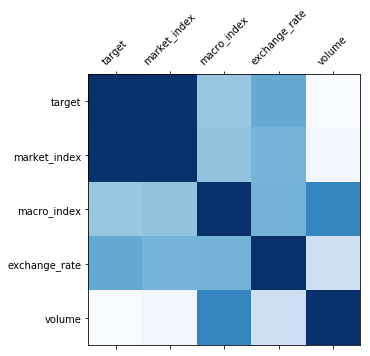

In [15]:
plot_corr(df.iloc[:-1,:])

In [16]:
df_pc = df.pct_change()
df_pc.columns = [f'pc_{column}' for column in df.columns]

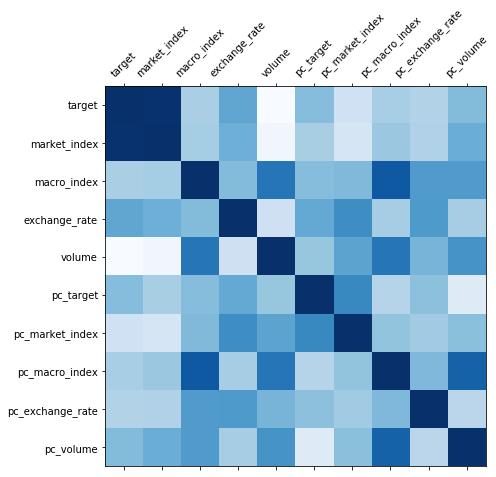

In [17]:
plot_corr(df.join(df_pc), size=7)

In [18]:
pd.DataFrame(StandardScaler().fit_transform(df), 
             columns=df.columns, 
             index=df.index).plot(figsize=(12, 7));
plt.title('Features Scaled');

In [19]:
print('D-F: source')
print_dickey_fuller(df)
print('D-F: percent change')
print_dickey_fuller(df_pc)
print('D-F: first diffs')
print_dickey_fuller(df.diff(1))

D-F: source
Dickey-Fuller for "target": 0.803
Dickey-Fuller for "market_index": 0.277
Dickey-Fuller for "macro_index": 0.001
Dickey-Fuller for "exchange_rate": 0.536
Dickey-Fuller for "volume": 0.903

D-F: percent change
Dickey-Fuller for "pc_target": 0.0
Dickey-Fuller for "pc_market_index": 0.002
Dickey-Fuller for "pc_macro_index": 0.0
Dickey-Fuller for "pc_exchange_rate": 0.169
Dickey-Fuller for "pc_volume": 0.0

D-F: first diffs
Dickey-Fuller for "target": 0.003
Dickey-Fuller for "market_index": 0.036
Dickey-Fuller for "macro_index": 0.0
Dickey-Fuller for "exchange_rate": 0.18
Dickey-Fuller for "volume": 0.0



## Baseline

### Create Validation

In [20]:
tscv = TimeSeriesSplit(n_splits=24)

In [21]:
def timeseriesCVscore(df, tscv=tscv, 
                      model=LinearRegression(), 
                      show_monthly=False, 
                      return_model=False):
    errors = []
    for train_loc, test_loc in tscv.split(df):
        y_train = df.iloc[train_loc]['target']
        X_train = df.iloc[train_loc, :].drop('target', axis=1)
        
        y_test = df.iloc[test_loc]['target']
        X_test = df.iloc[test_loc].drop('target', axis=1)

        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        error = abs(y_test.values - preds)

        if show_monthly:
            print(df.iloc[test_loc].index[0])
            print("y_hat: %2.4f, y: %2.4f, err: %2.4f" % (preds, y_test.values, error*100))
        errors.append(error)
    print('Mean confidence interval (last year)')
    print(mean_confidence_interval([x[0]*100 for x in errors[-12:]]))
    #return errors
    return model

### Train

In [22]:
timeseriesCVscore(df, show_monthly=False)

Mean confidence interval (last year)
(0.14306311579556039, 0.0707094464065829, 0.21541678518453788)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [23]:
dft = df.drop('target', axis=1).shift(1).fillna(method='bfill')
dft.columns = [f'lag_1{column}' for column in dft.columns]

In [24]:
timeseriesCVscore(df.join(dft))

Mean confidence interval (last year)
(0.13716552688966915, 0.036541476178829954, 0.23778957760050834)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [25]:
timeseriesCVscore(df.assign(
    volume=df.volume.diff(1)).fillna(method='bfill'))

Mean confidence interval (last year)
(0.12215019648693404, 0.030542078188275035, 0.21375831478559304)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [26]:
m = timeseriesCVscore(df.assign(
    volume=df.volume.pct_change()).fillna(method='bfill'), show_monthly=True, return_model=True)

2016-01-31 00:00:00
y_hat: 0.0897, y: 0.0932, err: 0.3432
2016-02-29 00:00:00
y_hat: 0.0775, y: 0.0936, err: 1.6064
2016-03-31 00:00:00
y_hat: 0.0890, y: 0.0929, err: 0.3879
2016-04-30 00:00:00
y_hat: 0.0905, y: 0.0925, err: 0.1991
2016-05-31 00:00:00
y_hat: 0.0897, y: 0.0915, err: 0.1790
2016-06-30 00:00:00
y_hat: 0.0875, y: 0.0879, err: 0.0406
2016-07-31 00:00:00
y_hat: 0.0850, y: 0.0858, err: 0.0797
2016-08-31 00:00:00
y_hat: 0.0833, y: 0.0836, err: 0.0279
2016-09-30 00:00:00
y_hat: 0.0821, y: 0.0789, err: 0.3185
2016-10-31 00:00:00
y_hat: 0.0826, y: 0.0821, err: 0.0511
2016-11-30 00:00:00
y_hat: 0.0814, y: 0.0821, err: 0.0670
2016-12-31 00:00:00
y_hat: 0.0775, y: 0.0798, err: 0.2336
2017-01-31 00:00:00
y_hat: 0.0836, y: 0.0836, err: 0.0044
2017-02-28 00:00:00
y_hat: 0.0786, y: 0.0790, err: 0.0365
2017-03-31 00:00:00
y_hat: 0.0763, y: 0.0732, err: 0.3135
2017-04-30 00:00:00
y_hat: 0.0799, y: 0.0792, err: 0.0696
2017-05-31 00:00:00
y_hat: 0.0756, y: 0.0754, err: 0.0273
2017-06-30 00:

## Volume Forecast

Dickey-Fuller: p=0.884540


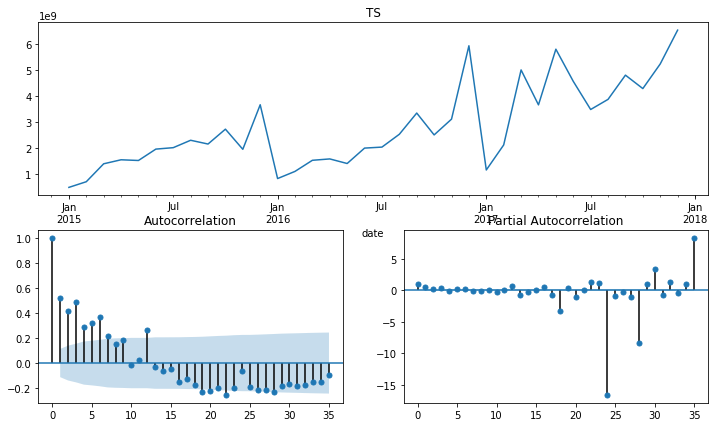

In [27]:
tsplot(df.volume)

Dickey-Fuller: p=0.000001


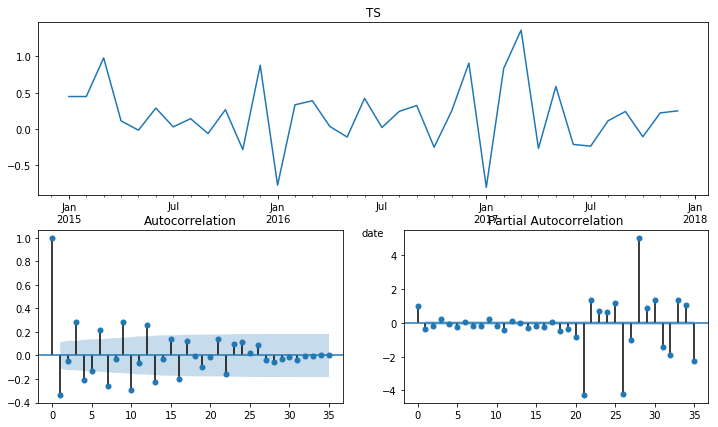

In [28]:
tsplot(df.volume.pct_change().fillna(method='bfill'))

In [29]:
ts = df.volume.pct_change()

In [30]:
n_steps = 12
model = SARIMAX(ts, seasonal_order=(0, 1, 0, 12))
model_fit = model.fit(maxiter=50, disp=None)
vol = model_fit.forecast(steps=1)
vol

2018-01-31   -0.696609
Freq: M, dtype: float64

## Interest Rate Forecast

In [31]:
test

date             2018-01-31 00:00:00
target                             ?
market_index                   0.085
macro_index                       50
exchange_rate                     60
volume                           NaN
Name: 36, dtype: object

In [32]:
X = np.array([0.085, 50, 60, vol.values[0]])

In [33]:
m.predict(X.reshape(1, -1))*100

array([8.60628824])

Предсказание ставки на 01/2018: 

8.6%